In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
%matplotlib inline
!pwd

/scratch/1/martners/GraphLearn_examples/Abstract


In [3]:
'''
GET RNA DATA
'''
from eden.converter.fasta import fasta_to_sequence
import itertools

def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)
def rfam_uri(family_id):
    return '%s.fa'%(family_id)
 
def get_graphss(rfam_id = '../toolsdata/RF00005'):
    return fasta_to_sequence(rfam_uri(rfam_id))

def get_graphs(rfam_id = '../toolsdata/RF00005', count=100):
    for a,b in itertools.islice( get_graphss(rfam_id),count):
        yield b

from eden.converter.fasta import fasta_to_sequence
def get_sequences(size=9999):
    sequences = itertools.islice( fasta_to_sequence("../toolsdata/RF00005.fa"), size)
    return [ b for (a,b) in sequences ]

def get_sequences_with_names(size=9999):
    sequences = itertools.islice( fasta_to_sequence("../toolsdata/RF00005.fa"), size)
    return sequences

DEMONSTRATING GRAPH MANAGER
grammar example 4


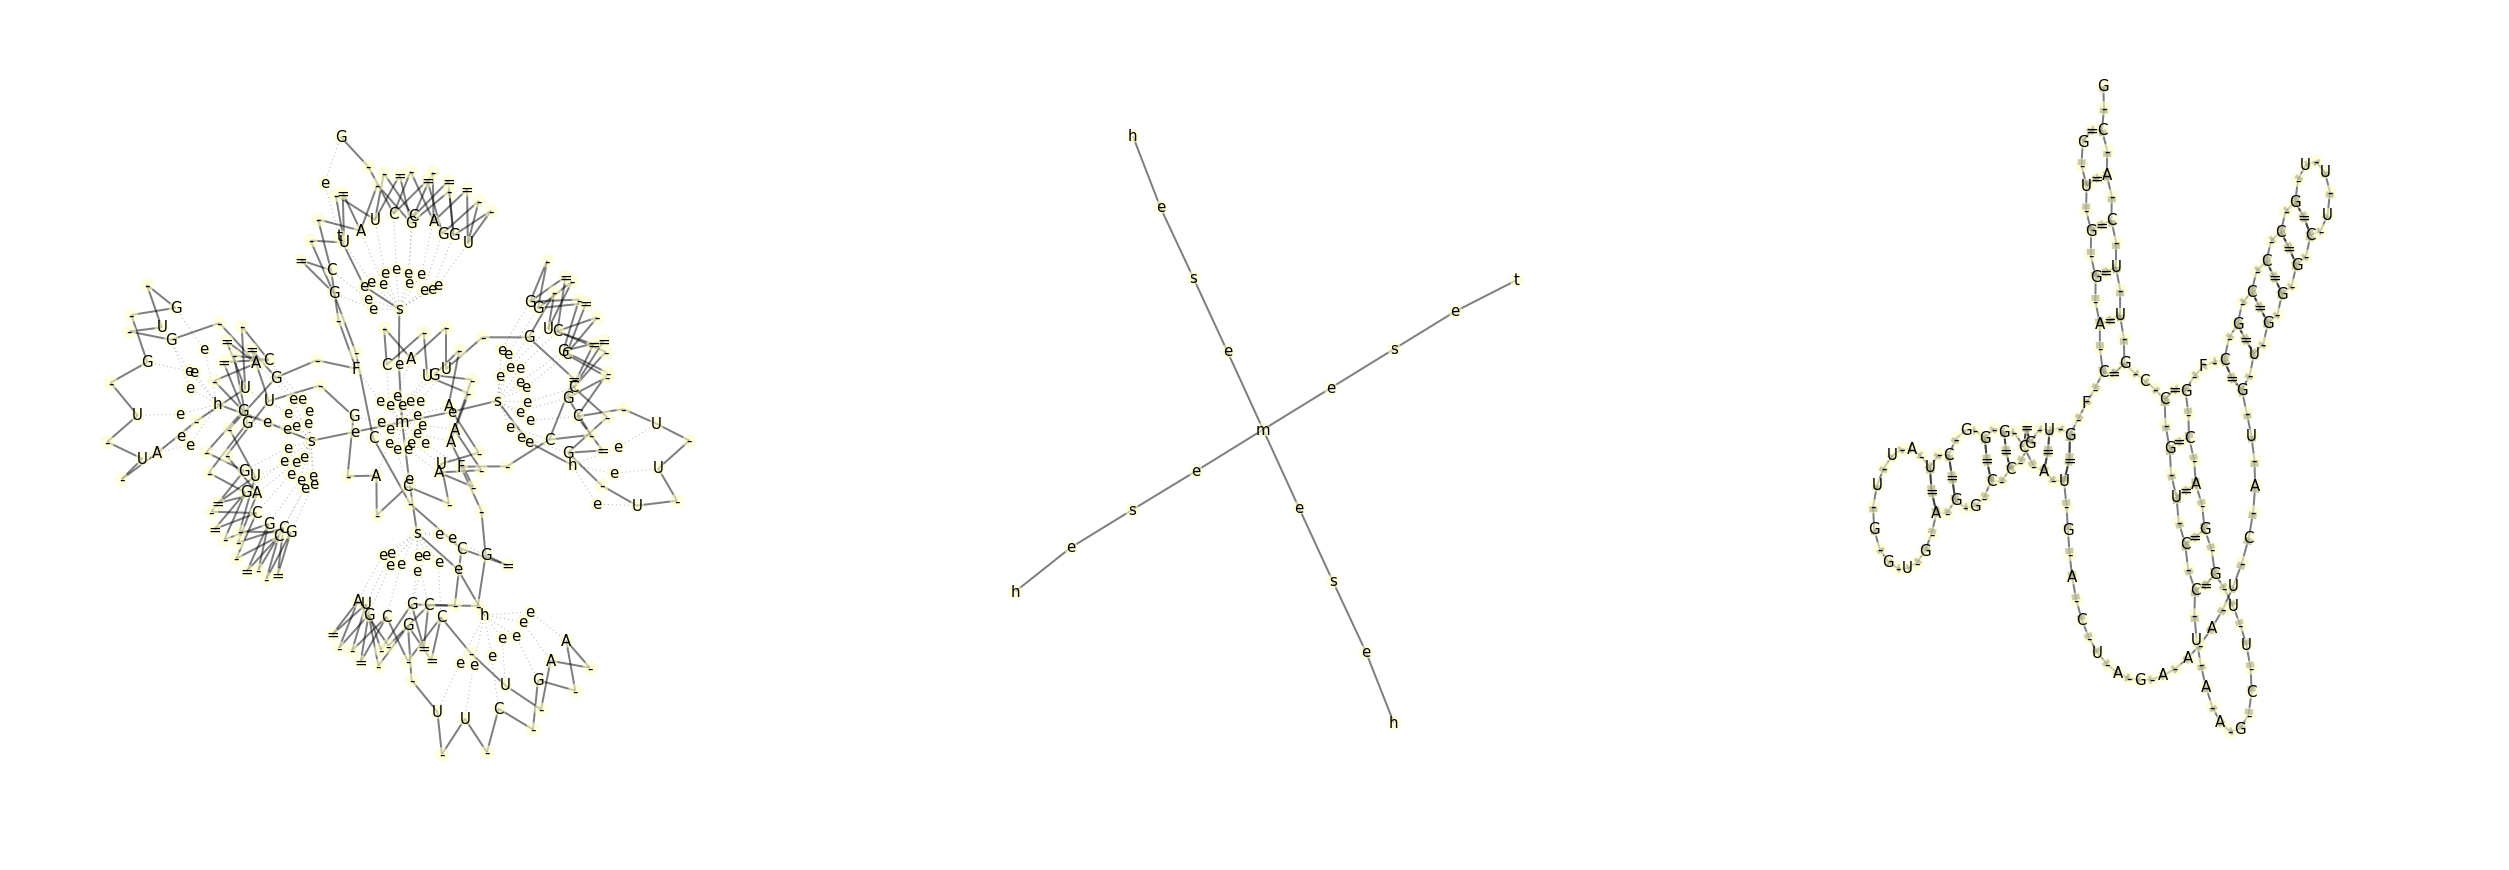

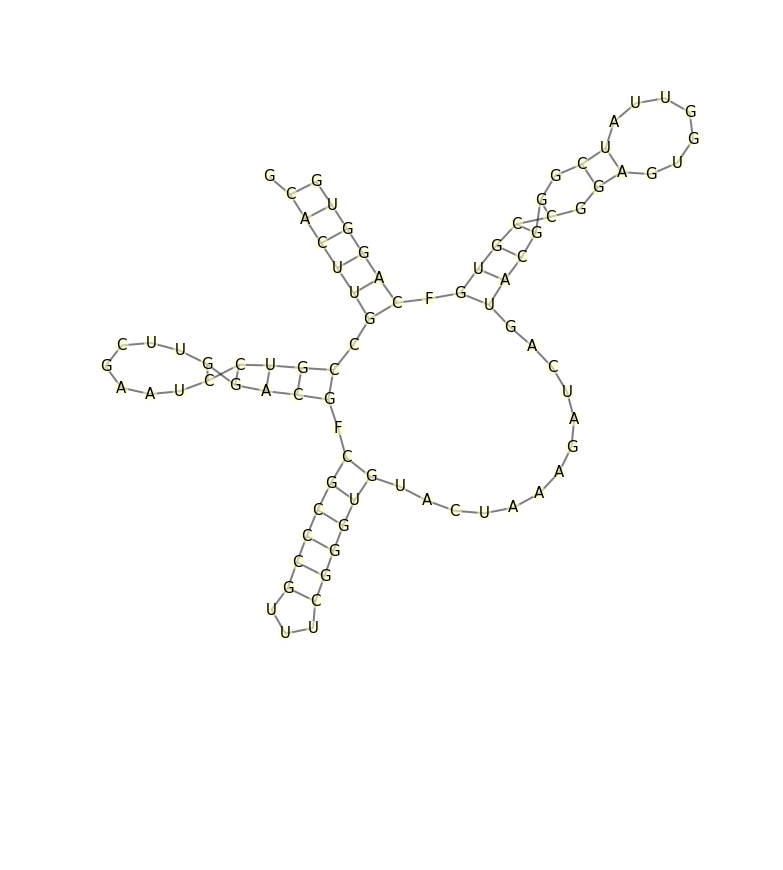

GUGGACFGUGCCGGAGUGGUUAUCGGGCAUGACUAGAAAUCAUGUGGGCUUUGCCCGCFGCAGGUUCGAAUCCUGCCGUUCACG
((((((.(((((.((.......)).))))).............((((((...)))))).(((((.......))))).)))))).


'\nprint \'DEMONSTRATING EXTRACTION\'  \n#prepare\nradius_list=[0,2]\nthickness_list=[2,4]\nbase_thickness_list=[2]\nf=lambda x, y: True\nd={\'radius_list\':radius_list,\n    \'thickness_list\':thickness_list,\n    \'hash_bitmask\':2**20-1,\n    \'node_filter\': f}\n\n\n#draw.graphlearn([gm.abstract_graph(),gm.base_graph()], size = 15,vertex_label = \'id\',contract=True)\ncips=gm.all_core_interface_pairs(**d)\nfor li, ciplist in enumerate(cips):\n    for entry, cip in enumerate(ciplist):\n        continue\n        z=\'list: %d ; entry: %d\' % (li,entry)\n        #cip.graph.graph[\'info\']=z\n        draw.graphlearn([cip.graph,cip.abstract_view], size=4, contract=True) \ncipz=[cips[2][3],cips[1][3],cips[1][2]]\ngraphz=[[c.graph,c.abstract_view] for c in cipz]\n    \n#g=gm.graph(nested=False)\n#print \'test\', g.nodes(data=True)[0][1]\n\n#for graphpair in graphz:\n#    draw.graphlearn(graphpair, size=10,font_size=36,# secondary_vertex_label=\'ID\',\n#                   colormap=\'Paired\

In [4]:
'''TESTING EXTRACTION AND GRAPHMANAGER'''
from graphlearn.utils import draw
import graphlearn.abstract_graphs.RNA as rna
from graphlearn.graphlearn import Sampler as GLS
from eden.graph import Vectorizer

vectorizer=Vectorizer()
pp=rna.PreProcessor(ignore_inserts=True)
pp.fit(get_sequences_with_names(),vectorizer)
graphmanagers=pp.transform(get_sequences()[:20])

print 'DEMONSTRATING GRAPH MANAGER'

for i in [4]:
    print 'grammar example %d' % i
    gm=graphmanagers[i]
    g=gm.graph(nested=True)
    #print g.nodes(data=True)
    #g.node[0].pop('weight')
    # jump because we do the thesis now
    #vec=vectorizer.transform_single(g)
    draw.graphlearn([gm.graph(nested=True),gm.abstract_graph(),gm.base_graph()], size = 15,vertex_label = 'label',contract=False)
    draw.graphlearn([gm.base_graph()], size = 15,vertex_label = 'label',contract=True)
    
    print gm.sequence
    print gm.structure
    
    
    
    
'''
print 'DEMONSTRATING EXTRACTION'  
#prepare
radius_list=[0,2]
thickness_list=[2,4]
base_thickness_list=[2]
f=lambda x, y: True
d={'radius_list':radius_list,
    'thickness_list':thickness_list,
    'hash_bitmask':2**20-1,
    'node_filter': f}


#draw.graphlearn([gm.abstract_graph(),gm.base_graph()], size = 15,vertex_label = 'id',contract=True)
cips=gm.all_core_interface_pairs(**d)
for li, ciplist in enumerate(cips):
    for entry, cip in enumerate(ciplist):
        continue
        z='list: %d ; entry: %d' % (li,entry)
        #cip.graph.graph['info']=z
        draw.graphlearn([cip.graph,cip.abstract_view], size=4, contract=True) 
cipz=[cips[2][3],cips[1][3],cips[1][2]]
graphz=[[c.graph,c.abstract_view] for c in cipz]
    
#g=gm.graph(nested=False)
#print 'test', g.nodes(data=True)[0][1]

#for graphpair in graphz:
#    draw.graphlearn(graphpair, size=10,font_size=36,# secondary_vertex_label='ID',
#                   colormap='Paired', invert_colormap=False,node_border=0.5,contract=True,
#                   vertex_alpha=0.5, node_size=1900)
    
    
    
minor = gm.abstract_graph()
minorcip = graphz[0][1]

def wire(g,nset=[]):
    for n in nset:
        z=str(n)
        g.add_edge("+"+z,"-"+z,nesting=True,weight='.2',len=2)
        
draw.graphlearn([minor,minorcip], size=10,font_size=36,# secondary_vertex_label='ID',
                   colormap='Paired', invert_colormap=False,node_border=0.5,contract=True,
                   vertex_alpha=0.5, node_size=1900)
#[minor,minorcip]

def colorize(g,c1=[],c2=[],c3=[],label='mycolors'):
    for n,d in g.nodes(data=True):
        if n in c1:
            d[label]='#C88A68' #reddish
        elif n in c2: 
            d[label]='#FAF4B0' # yellow
        elif n in c3:
            d[label]='#C9BC24' # dark yellow
        else:
            d[label]='#C1DDEB' # default color -- blueish

colorize(minor,c1=[2,3],c2=[5,9,10,0],c3=[])
colorize(minorcip,c1=[2,3],c2=[5,9,10,0],c3=[])
#g3=draw.cip_to_drawable_graph(cips=[cips[2][3]], graphs=[minor])

draw.graphlearn([minor,minorcip], size=10,font_size=36, #secondary_vertex_label='id',
                    contract=True,
                   colormap='Paired', invert_colormap=False,node_border=0.5,vertex_color='mycolors',
                   vertex_alpha=0.5, node_size=1900)
'''

In [5]:
%%time
'''
learning a grammar
'''
import graphlearn.abstract_graphs.RNA as rna
from  graphlearn.feasibility import FeasibilityChecker as Checker
import graphlearn.estimator as estimator
# not really needed since after refolding we get an RNA
#feasibility=Checker()
#feasibility.checklist.append(rna.is_rna)
graphs = get_sequences_with_names(size=200)
estimator=estimator.Wrapper( nu=.33, cv=2, n_jobs=-1)
sampler=rna.AbstractSampler(radius_list=[0,1],
                            thickness_list=[2], 
                            min_cip_count=1, 
                            min_interface_count=2, 
                            preprocessor=rna.PreProcessor(base_thickness_list=[1],ignore_inserts=True), 
                            postprocessor=rna.PostProcessor(),
                            estimator=estimator
                            #feasibility_checker=feasibility
                           )
sampler.fit(graphs,grammar_n_jobs=1,grammar_batch_size=1)
sampler.save('../tmp/rna_ubergrammar.ge')


CPU times: user 1min 34s, sys: 2.73 s, total: 1min 36s
Wall time: 2min 15s


interface id: 192835 [110 options]


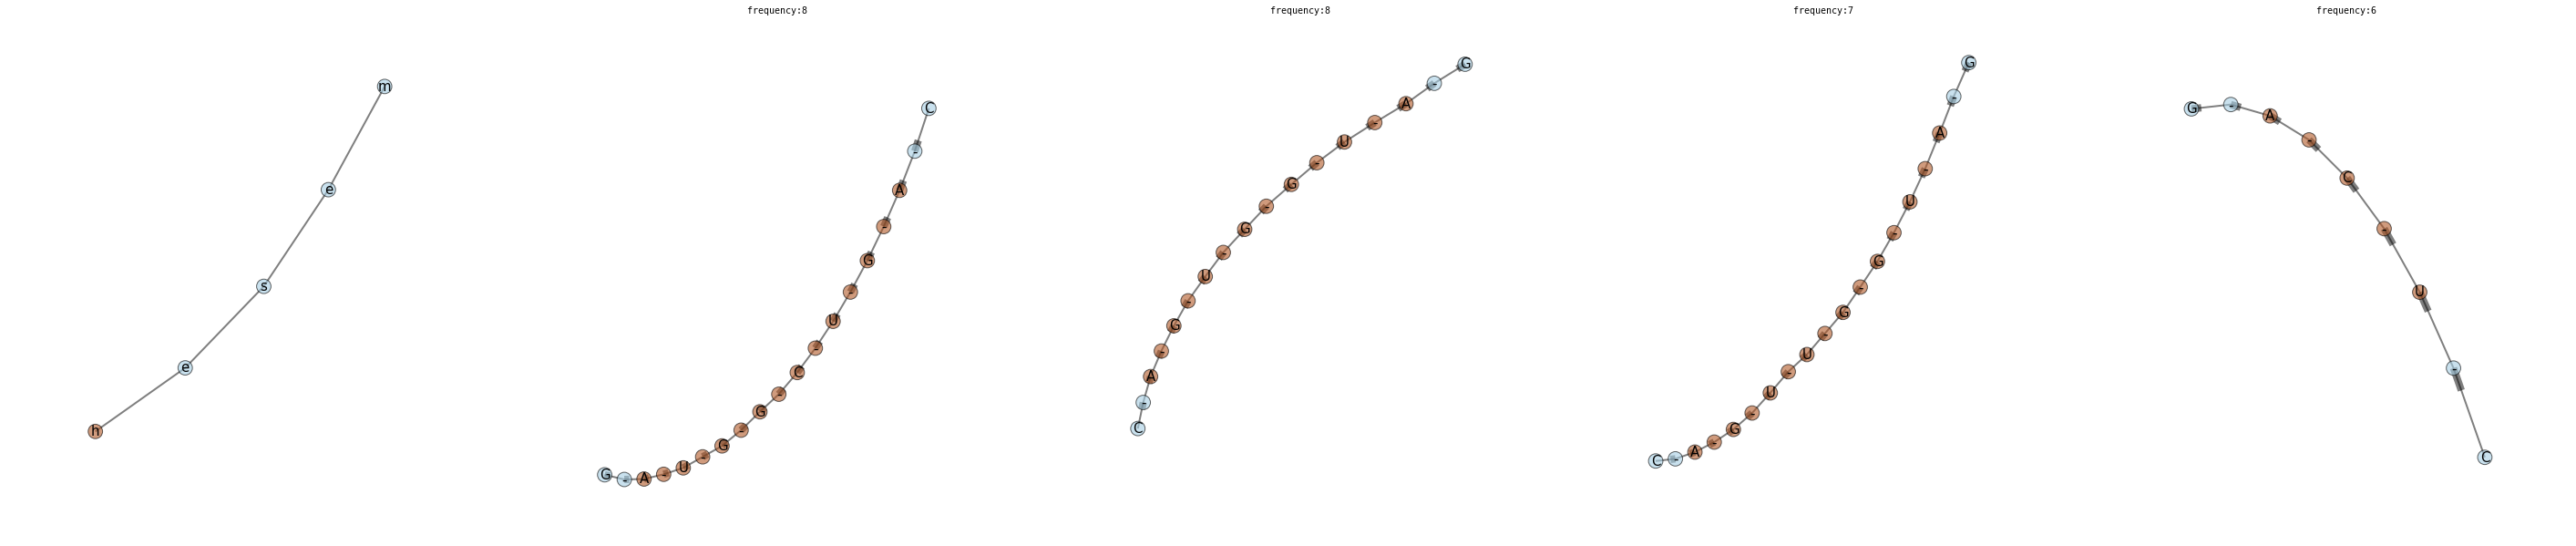

interface id: 355475 [101 options]


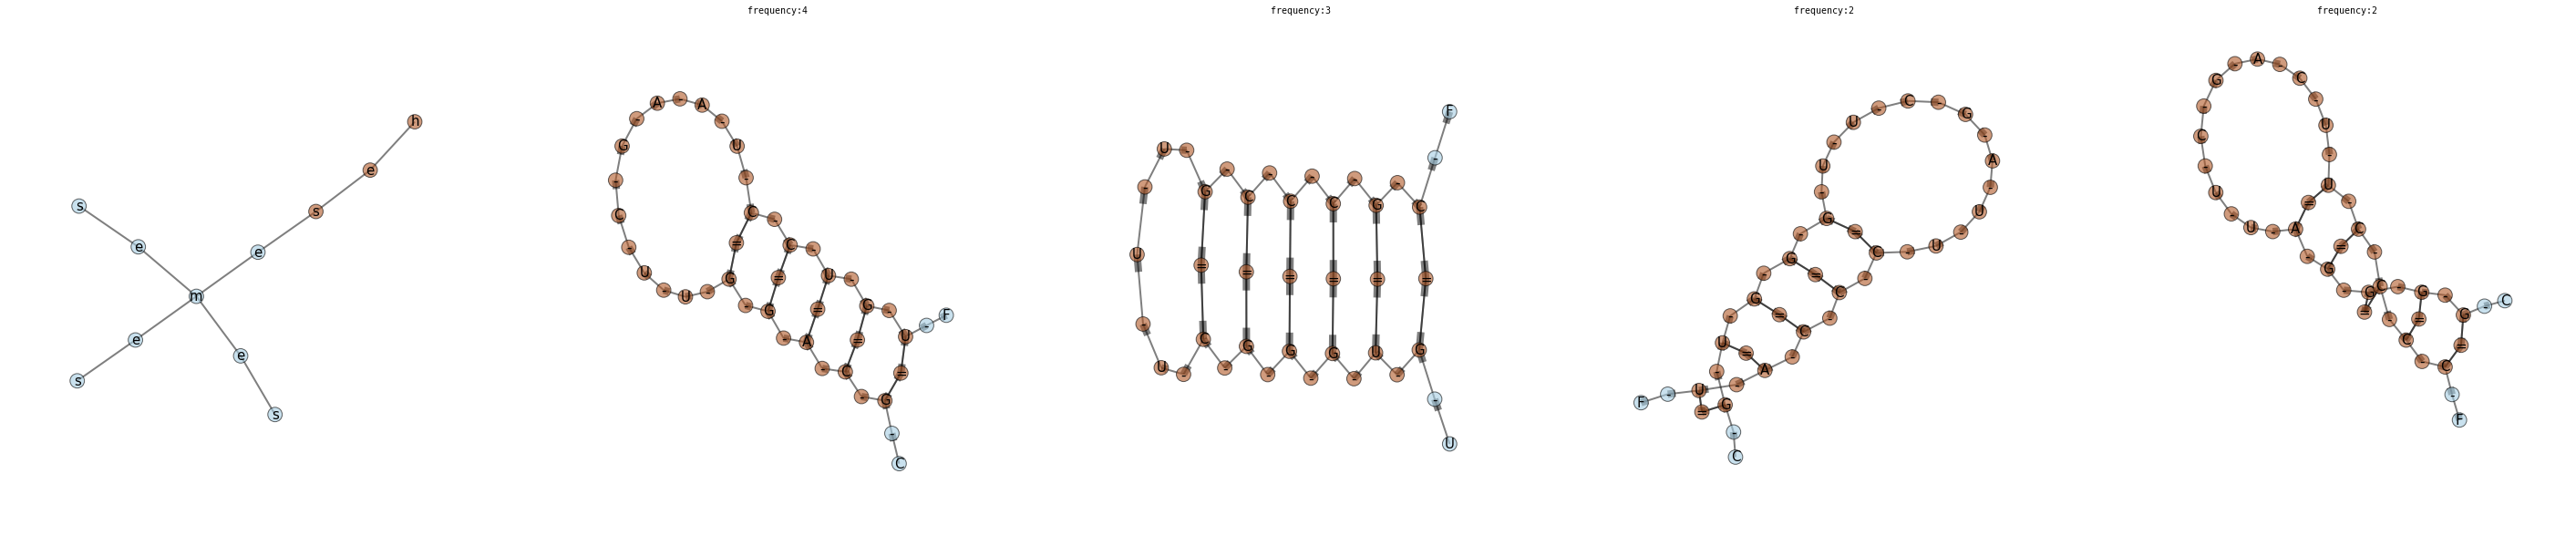

interface id: 353053 [94 options]


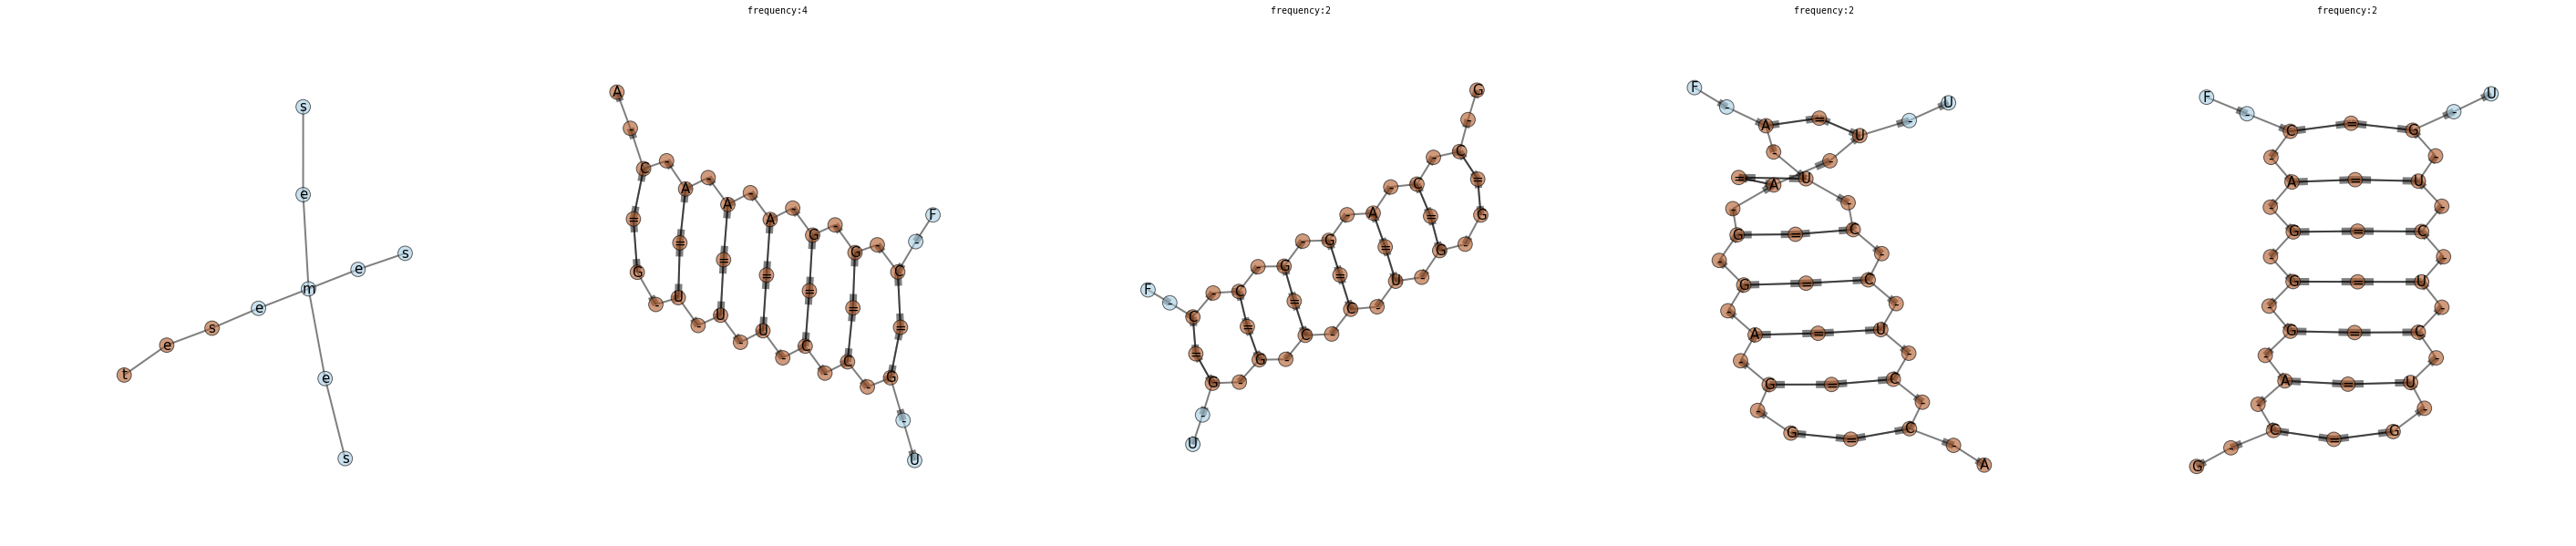

interface id: 733955 [75 options]


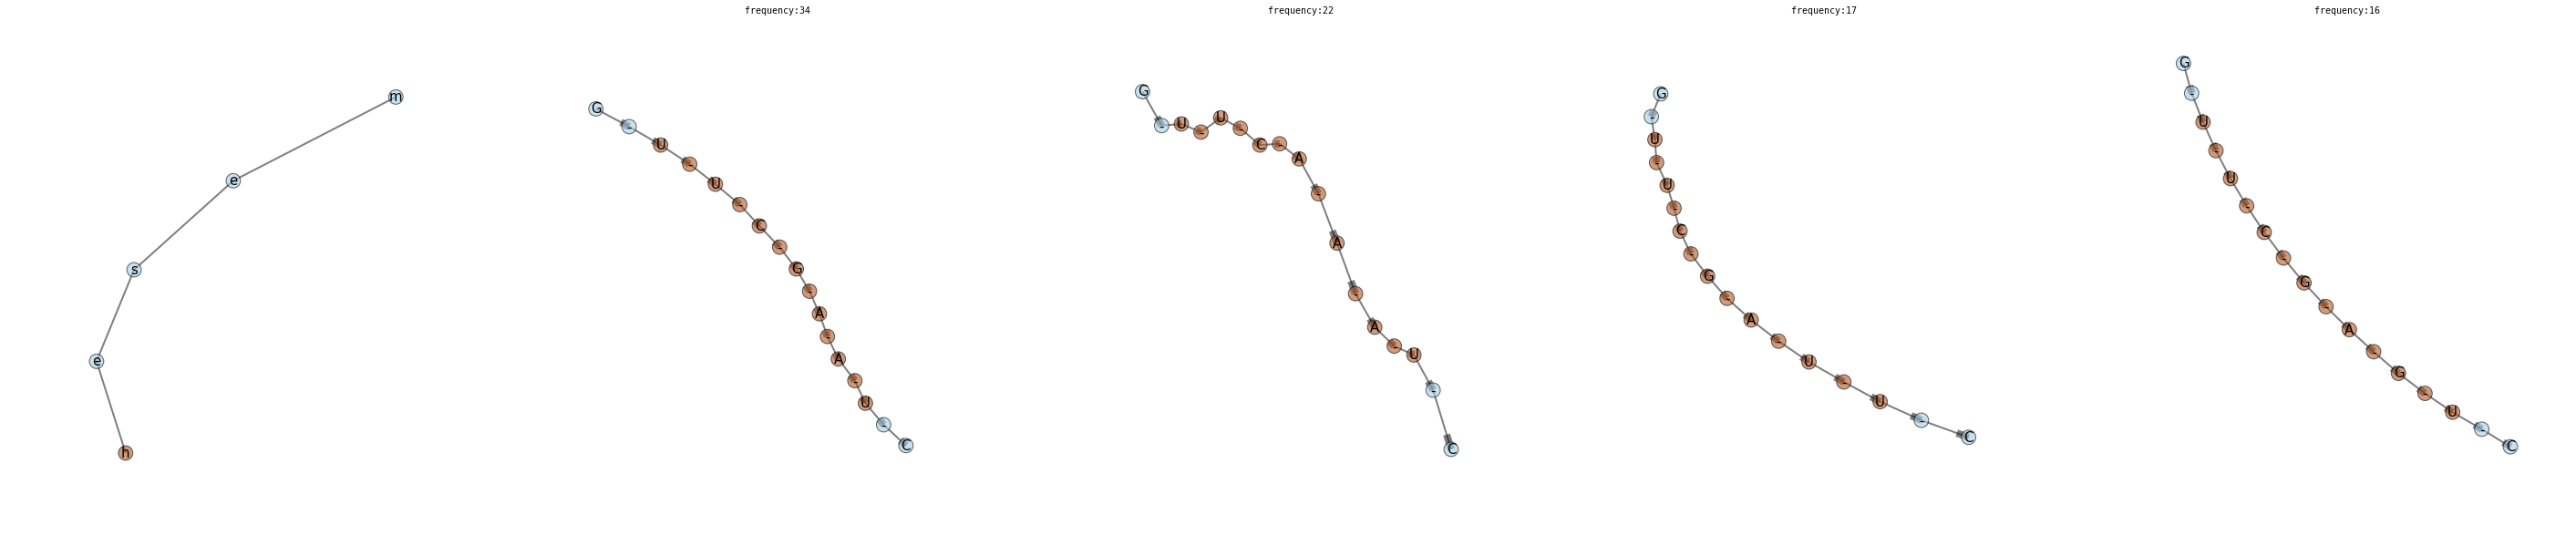

interface id: 250334 [61 options]


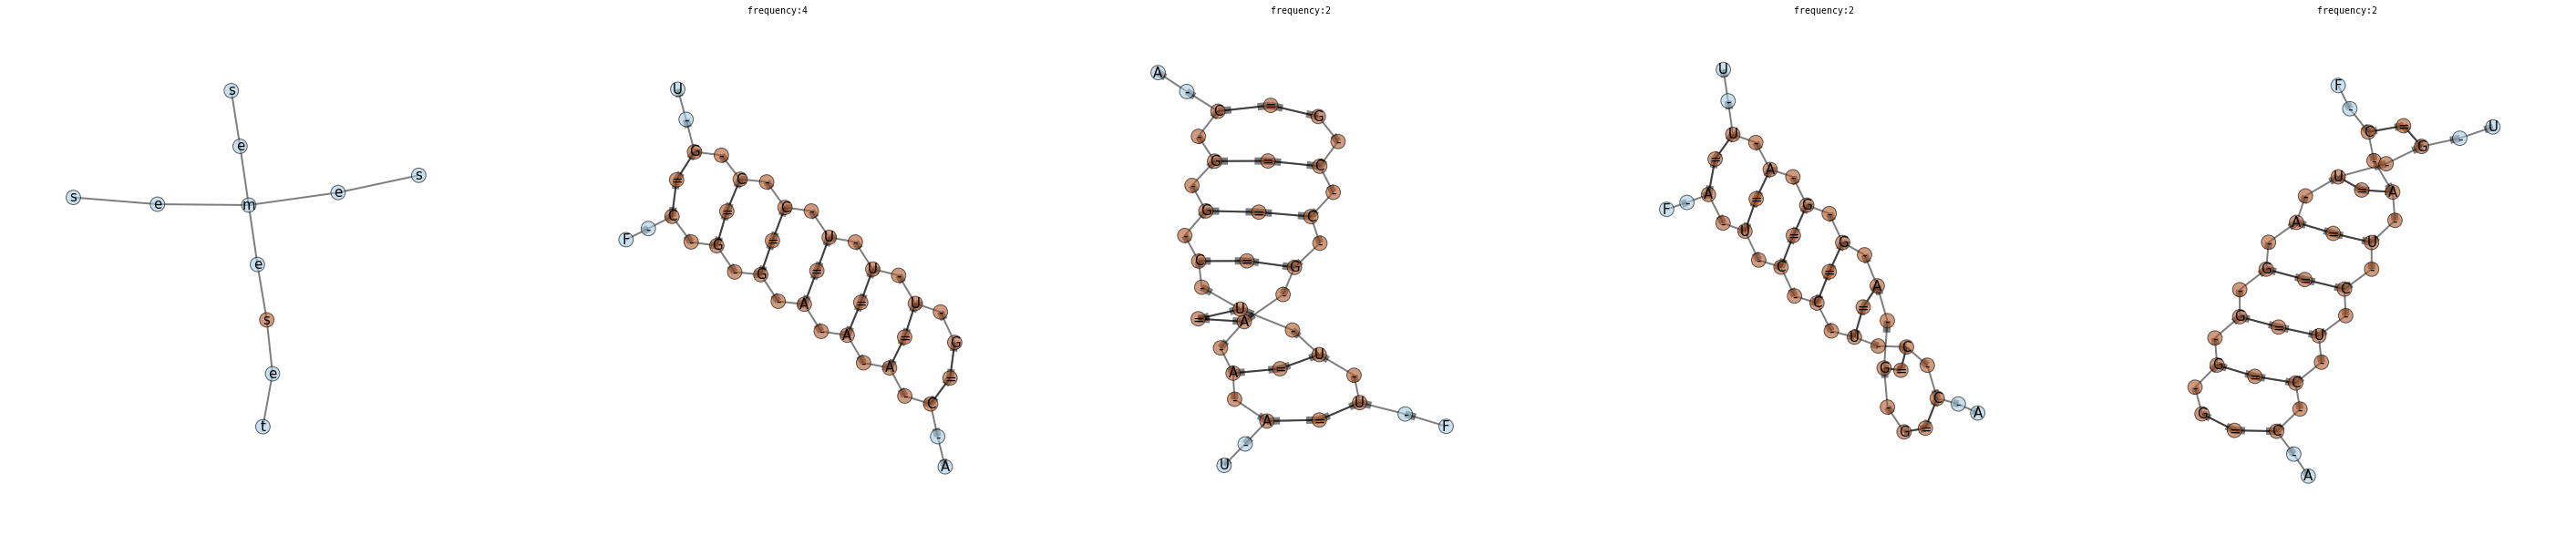

In [6]:
#draw production rules
draw.draw_grammar(sampler.lsgg.productions,n_productions=5,n_graphs_per_production=5,
                     n_graphs_per_line=6, size=10, contract=False,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=250, abstract_interface=True)

    

In [ ]:
%%time
'''
Rna sampling
'''
import os
os.nice(19)
import graphlearn.utils.draw as draw
import graphlearn.abstract_graphs.RNA as rna
from graphlearn.graphlearn import Sampler as GLS
import itertools
#sampler=rna.AbstractSampler(radius_list=[0,1],thickness_list=[2], min_cip_count=1, min_interface_count=2, preprocessor=rna.PreProcessor(), postprocessor=rna.PostProcessor())
#sampler.load('tmp/rna_ubergrammar.ge')


graphs = get_graphs()
id_start=66
id_end=id_start+12
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=100

graphs = sampler.sample(graphs,
                        n_samples=3,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=4,
                        quick_skip_orig_cip=True,
                        probabilistic_core_choice=True,
                        burnin=0,
                        improving_threshold=0.7,
                        improving_linear_start=0.2,
                        max_size_diff=20,
                        accept_min_similarity=0.65,
                        select_cip_max_tries=30,
                        keep_duplicates=False,
                        include_seed=True,
                        backtrack=10,
                        monitor=True)


from eden.modifier.graph.vertex_attributes import colorize   
scores=[]
sequences=[]
ids=range(id_start,id_end)
for i,graphlist in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(sampler.monitors[i].sampling_info['score_history'])
    print 'alive'
    sequences.append(sampler.monitors[i].sampling_info['notes'])
    '''
    z=[]
    for a,b in graphlist:
        z.append(b)
    print z
    '''
    print 'still alive'
    #path_graphs = colorize(graphlist,
    #                       output_attribute = 'color_level', 
    #                       labels = ['A','U','G','C'])
    print 'going to draw'
    draw.graphlearn(graphlist,
                           n_graphs_per_line=3, size=20, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.7, node_size=450,edge_label='label' )


In [8]:
    draw.graphlearn(path_graphs,
                           n_graphs_per_line=3, size=20, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.7, node_size=450,edge_label='label' )

[<networkx.classes.digraph.DiGraph object at 0x7fcafc1394d0>, <networkx.classes.digraph.DiGraph object at 0x7fcaf8b0a790>, <networkx.classes.digraph.DiGraph object at 0x7fcaf8b0aad0>]


In [ ]:
'''
%matplotlib inline
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt

step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()
    
'''
    
    

In [ ]:
'''
draw the score history for each of the graphs
'''
colors=['b','g','r','c','m','y','k','w']

%matplotlib inline
from itertools import islice
import matplotlib.pyplot as plt
import numpy as np
step=1
num_graphs_per_plot=2
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data,ls='-',color=colors[j], label='graph %d'%(j+i*num_graphs_per_plot+id_start))

        # okok now we need to add the infernal evaluation
        seqs=sequences[i*num_graphs_per_plot+j]
        seqs=seqs.split('n')
        
        # SEQUENCES STILL CONTAIN F, ALSO THERE ARE ERRORMESSAGES AT THE END OF INFO
        #seqs=seqs[:-1]
    
        #print seqs
        data2= rna.infernal_checker(seqs,cmfile='../rf00005.cm')
        #print data2,seqs
        plt.plot(data2,ls='--',color=colors[j], label='infernal %d'%(j+i*num_graphs_per_plot+id_start))
    plt.plot([0.29]*len(data2),ls='-.',color='r', label='significance') #| '-' | '--' | '-.' | ':' | 'None' | ' ' |
    plt.legend(loc='lower left',framealpha=0.5)
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

In [ ]:
import graphlearn.abstract_graphs.RNA as rna
import graphlearn.utils.draw as draw

#faillist=[0,2,4,5]
# for every failed graph

runs=[]
for i,mon in enumerate(sampler.monitors):
    lastgraph=None
    run=[]
    for t,graphs in mon.format(start=0):
        if lastgraph!=None:
            v=sampler.vectorizer.similarity([graphs[0].copy()],lastgraph).next()
            
            run.append(v)
        lastgraph=graphs[0]
    runs.append(run)
import numpy
for run in runs:
    a= numpy.array(run)
    print numpy.mean(a, axis=0),' ',numpy.std(a, axis=0)
    
    
    '''
    if len(mon.content) < 80:
        for t,graphs in mon.format(start=0):
            # print relevant info

            draw.graphlearn(graphs,size=6,node_border=.5)

            lastgraph=graphs[0]
            
        print "#"*80
        print "#"*80
        break
            #print monentry['graphwrapper'].sequence
            #print monentry['graphwrapper'].structure
            
            
            
            
            

In [18]: arr =

In [20]: numpy.mean(arr, axis=0)
Out[20]: 
array([ 0.7       ,  2.2       ,  1.8       ,  2.13333333,  3.36666667,
        5.1       ])

In [21]: numpy.std(arr, axis=0)
Out[21]: 
array([ 0.45460606,  1.29614814,  1.37355985,  1.50628314,  1.15566239,
        1.2083046 ])
    '''

In [ ]:
print run
    


In [ ]:

import networkx as nx
import graphlearn.utils.draw as draw
from eden.graph import Vectorizer

v=Vectorizer()
def getpathgraph(labels):
    nlabels= len(labels)
    G=nx.path_graph(nlabels)
    for e in range(nlabels):
        G.node[e]['label']=labels[e]
    for e in range(nlabels-1):
        G.edge[e][e+1]['label']='.'
    return G

g=getpathgraph("ABC")

g= v._edge_to_vertex_transform(g)

draw.graphlearn_draw(g,contract=False,show_direction=True)

g2=nx.DiGraph(g)
#draw.display(g2,contract=False,vertex_label='id')

for n,d in g2.nodes(data=True):
    if 'edge' in d:
        if d['label']=='.':
            ns=g2.neighbors(n)
            g2.remove_edge(ns[1],n)
            g2.remove_edge(n,ns[0])
          
       
#g2 = g2.to_undirected()
draw.graphlearn(g2,contract=False,vertex_label='id',show_direction=True)
g2.edges()
for n in g2.nodes():
    print n,g2.neighbors(n)
print isinstance(g2, nx.DiGraph) 

In [ ]:
g2.edges(0,data=True)

In [ ]:
asd = g2.subgraph(range(2)).copy()

In [ ]:
class A(object):
    def __init__(self,a=123):
        self.a=a
        
        
class B(A):
    def __init__(self,b=122):
        super(B,self).__init__(b)
        
        

class C(A):
    def __init__(self,c=121):
        super(C,self).__init__(c)
        
        
c=C()
c.a
        
        
        
    
    

In [ ]:
# testin cycle stuff
import networkx as nx
import graphlearn.utils.draw as draw
import graphlearn.feasibility as feas
from eden.graph import Vectorizer
v=Vectorizer()
%matplotlib inline


def find_all_cycles(G, source=None, cycle_length_limit=None):
    """forked from networkx dfs_edges function. Assumes nodes are integers, or at least
    types which work with min() and > ."""
    if source is None:
        # produce edges for all components
        nodes=[i[0] for i in nx.connected_components(G)]
    else:
        # produce edges for components with source
        nodes=[source]
    # extra variables for cycle detection:
    cycle_stack = []
    output_cycles = set()
    
    def get_hashable_cycle(cycle):
        """cycle as a tuple in a deterministic order."""
        m = min(cycle)
        mi = cycle.index(m)
        mi_plus_1 = mi + 1 if mi < len(cycle) - 1 else 0
        if cycle[mi-1] > cycle[mi_plus_1]:
            result = cycle[mi:] + cycle[:mi]
        else:
            result = list(reversed(cycle[:mi_plus_1])) + list(reversed(cycle[mi_plus_1:]))
        return tuple(result)
    
    for start in nodes:
        if start in cycle_stack:
            continue
        cycle_stack.append(start)
        
        stack = [(start,iter(G[start]))]
        while stack:
            parent,children = stack[-1]
            try:
                child = next(children)
                
                if child not in cycle_stack:
                    cycle_stack.append(child)
                    stack.append((child,iter(G[child])))
                else:
                    i = cycle_stack.index(child)
                    if i < len(cycle_stack) - 2: 
                      output_cycles.add(get_hashable_cycle(cycle_stack[i:]))
                
            except StopIteration:
                stack.pop()
                cycle_stack.pop()
    
    return [list(i) for i in output_cycles]


def getpathgraph(labels):
    nlabels= len(labels)
    G=nx.path_graph(nlabels)
    for e in range(nlabels):
        G.node[e]['label']=labels[e]
    for e in range(nlabels-1):
        G.edge[e][e+1]['label']='.'
    return G

#g=getpathgraph("ABC")

#g= v._edge_to_vertex_transform(g)

#draw.graphlearn_draw(g,contract=False,show_direction=True)


#draw.display(g2,contract=False,vertex_label='id')

g=nx.cycle_graph(10)
g.add_edge(2,7)
g.add_edge(10,0)

draw.graphlearn_draw(g, vertex_label='id')


feas.rooted_problem_cycle(g,2,4)

In [ ]:
print g.graph

In [ ]:
stru,stri='(.((...))...)', 'aFaaaaaaaaaaa'



def pairs(s):
    "give me a bond dict"
    unpaired=[]
    pairs={}
    for i,c in enumerate(s):
        if c=='(':
            unpaired.append(i)
        if c==')':
            partner=unpaired.pop()
            pairs[i]=partner
            pairs[partner]=i
    return pairs



def fix_structure( stru,stri ):
    '''
    the problem is to check every (( and )) . 
    if the bonding partners are not next to each other we know that we need to act.
    '''
    p=pairs(stru)
    lastchar="."
    problems=[]
    for i,c in enumerate(stru):
        # checking for )) and ((
        if c==lastchar and c!='.':
            if abs(p[i]-p[i-1])!=1: #the partners are not next to each other
                problems.append(i)
        # )( provlem
        elif c=='(':
            if lastchar==')':
                problems.append(i)          
        lastchar=c
            
    problems.sort(reverse=True)
    for i in problems:
        stru=stru[:i]+'.'+stru[i:]
        stri=stri[:i]+'F'+stri[i:]

    return stru,stri
    

    
fix_structure(stru,stri)






In [ ]:
l=[[4,5],[3,4]]
l.sort()
l


In [ ]:
import graphlearn.abstract_graphs.RnaWrap as RW
from eden.converter.fasta import fasta_to_sequence   
seq = [ b for (a,b) in fasta_to_sequence("RF00005.fa") ] 
        
folder=RW.NearestNeighborFolding(seq,4)

folder.fold("GGGGCCUUAGCUCAGCUGGGAGAGCGCCUGCUUUGCACGCAGGAGGUCAGCGGUUCGAUGGCGCUAGGCUCCA")
a,b=folder.call_folder()
    


In [ ]:
import textwrap
textwrap.wrap("asdasdasdasdasdasd", width=3)

In [ ]:
print a,b

In [ ]:
s="asdasdasdasd"
s.get(z,123)

In [ ]:
z=[1,2,3]
z.reverse()
z

In [ ]:
def lol():
    print "a"
    return False

if True or lol():
    pass

In [ ]:

import networkx as nx
import eden.modifier.rna.lib_forgi as lib_forgi



def make_abstract_graph(forgi):
    g=forgi_to_graph(forgi)
    connect_multiloop(g)
    return g


def forgi_to_graph(forgi, ignore_inserts=True):
    def make_node_set(numbers):
        '''
        forgi gives me stuff like define STEM START,END,START,END .. we take indices and output a list
        '''
        numbers=map(int,numbers)
        ans=set()
        while len(numbers)>1:
            a,b = numbers[:2]
            numbers=numbers[2:]
            for n in range(a-1,b): ans.add(n) # should be range a,b+1 but the biologists are weired
        return ans


    def get_pairs(things):
        '''
        '''
        current=[]
        for thing in things:
            if thing[0]=='m':
                current.append(thing)
            if len(current)==2:
                yield current
                current = []


    g=nx.Graph()
    fni={} # forgi name to networkx node id

    for l in forgi.split('\n')[:-1]:
        line= l.split()
        #only look at interesting lines
        if line[0] not in ['define','connect']:
            continue

        # parse stuff like: define s0 1 7 65 71
        if line[0]=='define':

            # get necessary attributes for a node
            label=line[1][0]
            id=line[1]
            myset=make_node_set(line[2:])
            node_id=len(g)

            # build a node and remember its id
            g.add_node(node_id)
            fni[id]=node_id
            g.node[node_id].update( {'label':label, 'contracted':myset}  )

        # parse stuff like this: connect s3 h2 m1 m3
        if line[0]=='connect':
            # get nx name of the first element.
            hero= fni[ line[1] ]
            # connect that hero to the following elements
            for fn in line[2:]:
                g.add_edge(hero, fni[fn])

            # remember what pairs multiloop pieces we are part of
            # i assume that if a stack is part of 2 multiloops they appear in order ..
            # this assumption may be wrong so be careful
            g.node[fni[line[1]]]['multipairs']=[]
            for a,b in get_pairs(line[2:]):
                g.node[fni[line[1]]]['multipairs'].append( (fni[a],fni[b]) )
    if ignore_inserts:
        # repair inserts by mergind adjacent stacks
        mergelist=[]
        for n,d in g.nodes(data=True):
            if d['label']=="i":
                neighs=g.neighbors(n)
                mergelist.append((neighs[0],(n,neighs[1])))
                
        # merged is keeping track of already merged nodes.
        # so we always know where to look for :) 
        merged={}
        for s1,mergers in mergelist:
            while s1 not in g.nodes():
                s1=merged[s1]
            for merger in mergers:
                while merger not in g.nodes():
                    merger=merged[merger]
                merge(g,s1,merger)
                merged[merger]=s1
    return g

def merge(graph, node, node2):
    '''
    merge node2 into the node.
    input nodes are strings,
    node is the king
    '''
    for n in graph.neighbors(node2):
        graph.add_edge(node, n)
    graph.node[node]['contracted'].update(graph.node[node2]['contracted'])
    graph.remove_node(node2)


def connect_multiloop(g):




    merge_dict={}
    for node,d in g.nodes(data=True):
        if d['label'] == 's':
            for a,b in g.node[node]['multipairs']:
                # finding real names... this works by walking up the
                #ladder merge history until the root is found :)
                while a not in g:
                    a=merge_dict[a]
                while b not in g:
                    b=merge_dict[b]
                if a==b:
                    continue
                merge_dict[b]=a
                merge(g,a,b)

s="((((((.(((((.((.......)).))))).............((((((...)))))).(((((.......))))).))))))."
bg = lib_forgi.BulgeGraph()
bg.from_dotbracket(s, None)
forgi = bg.to_bg_string()







def transform( original_graph):
        """Return a graph where the edges of the original_graph are converted to nodes."""

        # if operating on graphs that have already been subject to the
        # edge_to_vertex transformation, then do not repeat the transformation but
        # simply return the graph
        if 'expanded' in original_graph.graph:
            return original_graph
        else:
            graph = nx.Graph()
            graph.graph['expanded'] = True
            # build a graph that has as vertices the original vertex set
            for n, d in original_graph.nodes_iter(data=True):
                d['node'] = True
                graph.add_node(n, d)
            # and in addition a vertex for each edge
            new_node_id = max(original_graph.nodes()) + 1
            for u, v, d in original_graph.edges_iter(data=True):
                d['edge'] = True
                
                graph.add_node(new_node_id, d)
                print u,v,new_node_id
                # and the corresponding edges
                graph.add_edge(new_node_id, u, label=None)
                graph.add_edge(new_node_id, v, label=None)
                
                new_node_id += 1
            return graph




g=forgi_to_graph(forgi)
draw.graphlearn(g,contract=False,secondary_vertex_label='id')

if 2 in g[2]:
    g.remove_edge(2,2)
g = transform(g)
draw.graphlearn(g,contract=False,secondary_vertex_label='id',size=20)
#self._abstract_graph = forgi.edge_parent_finder(g, self._base_graph)


In [ ]:
def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)
print rfam_uri("RF00162")
print rfam_uri("RF01725")
